# Importaciones y configuración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML, display, clear_output
import ipywidgets as widgets
import time
from pso import *
from objective_functions import rastrigin

# Configuración de Matplotlib para el notebook
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Visualización de las distribuciones de inicialización

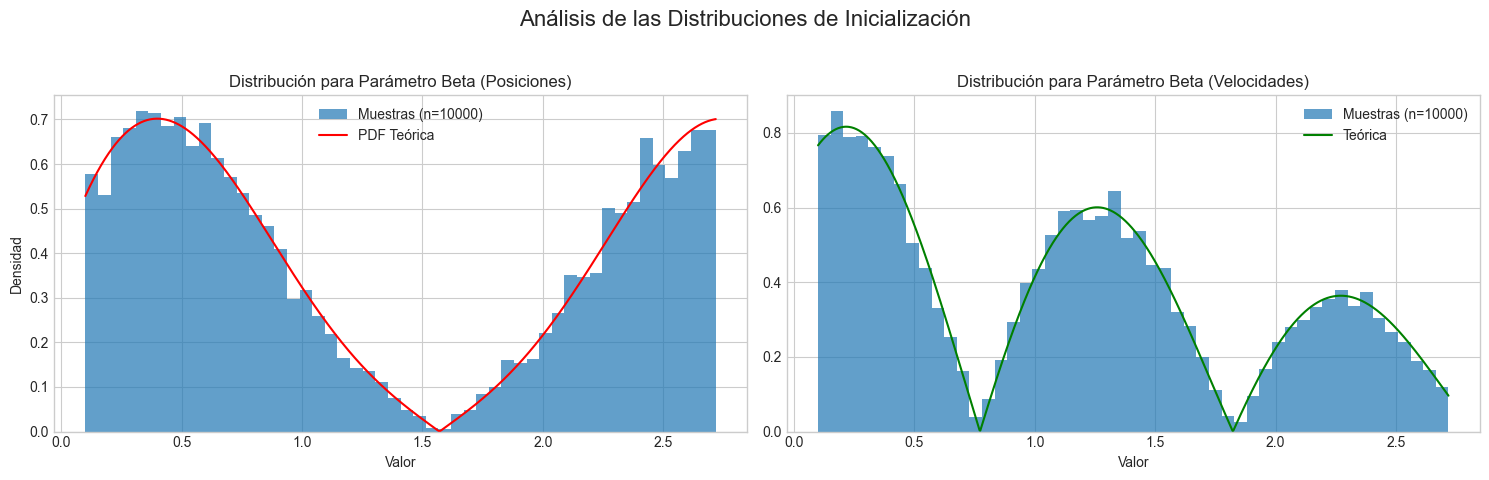

In [2]:
def plot_initialization_distributions(min_val=0.1, max_val=np.e, n=1000, sample_size=10000):
    """
    Visualiza las distribuciones de probabilidad utilizadas para inicializar
    las posiciones y velocidades de las partículas.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # --- Distribución para Posiciones ---
    values = np.linspace(start=min_val, stop=max_val, num=n)
    weights_pos = np.abs(np.sin(2 * values) + 0.5 * np.cos(3 * values))
    weights_pos /= weights_pos.sum()
    samples_pos = np.random.choice(values, size=sample_size, p=weights_pos)
    
    ax1.hist(samples_pos, bins=50, density=True, alpha=0.7, label=f'Muestras (n={sample_size})')
    ax1.plot(values, weights_pos * (n / (max_val - min_val)), color='red', label='PDF Teórica') # Escalar para que coincida
    ax1.set_title('Distribución para Parámetro Beta (Posiciones)')
    ax1.set_xlabel('Valor')
    ax1.set_ylabel('Densidad')
    ax1.legend()

    # --- Distribución para Velocidades ---
    weights_speed = np.abs(0.7 * np.sin(np.e * values) + 0.8 * np.cos(np.pi * values))
    weights_speed /= weights_speed.sum()
    samples_speed = np.random.choice(values, size=sample_size, p=weights_speed)
    
    ax2.hist(samples_speed, bins=50, density=True, alpha=0.7, label=f'Muestras (n={sample_size})')
    ax2.plot(values, weights_speed * (n / (max_val-min_val)), color='green', label='Teórica')
    ax2.set_title('Distribución para Parámetro Beta (Velocidades)')
    ax2.set_xlabel('Valor')
    ax2.legend()
    
    fig.suptitle('Análisis de las Distribuciones de Inicialización', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Ejecuta la función para ver los gráficos
plot_initialization_distributions()

# Visualización de la función objetivo

Visualización de la función de Rastrigin


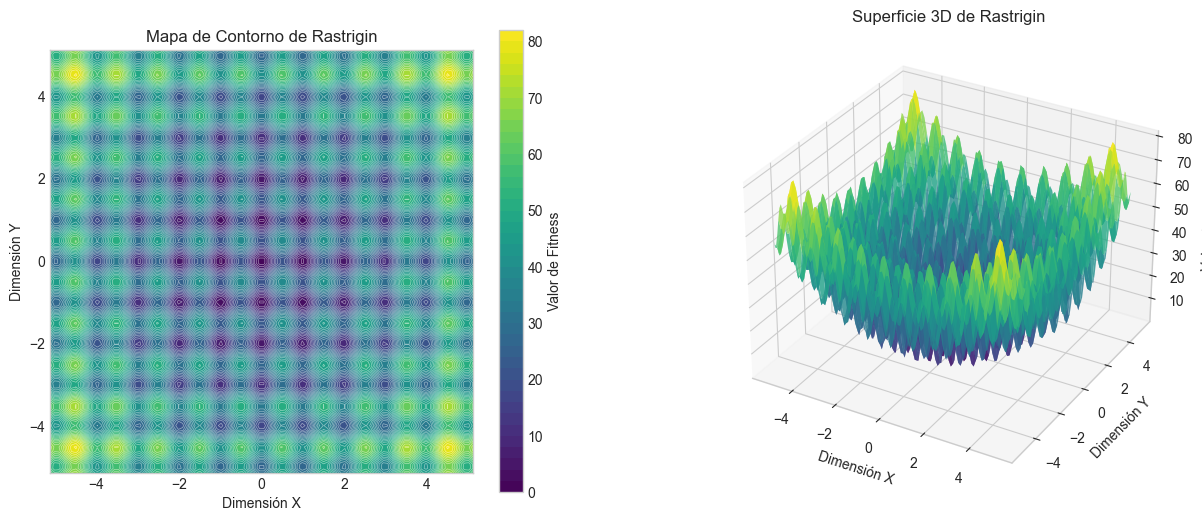

In [3]:
def plot_objective_function(func, bounds, title):
    x = np.linspace(bounds[0], bounds[1], 100)
    y = np.linspace(bounds[0], bounds[1], 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.array([func(np.array([x_i, y_i])) for x_i, y_i in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
    
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(1, 2, 1)
    contour = ax1.contourf(X, Y, Z, levels=50, cmap='viridis')
    ax1.contour(X, Y, Z, levels=50, colors='white', linewidths=0.5, alpha=0.5)
    fig.colorbar(contour, ax=ax1, label='Valor de Fitness')
    ax1.set_title(f'Mapa de Contorno de {title}')
    ax1.set_xlabel('Dimensión X')
    ax1.set_ylabel('Dimensión Y')
    ax1.set_aspect('equal', adjustable='box')
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
    ax2.set_title(f'Superficie 3D de {title}')
    ax2.set_xlabel('Dimensión X')
    ax2.set_ylabel('Dimensión Y')
    ax2.set_zlabel('Valor de Fitness')
    
    plt.show()

print("Visualización de la función de Rastrigin")
plot_objective_function(rastrigin, (-5.12, 5.12), "Rastrigin")

# Visualización de la Topología de Vecindario

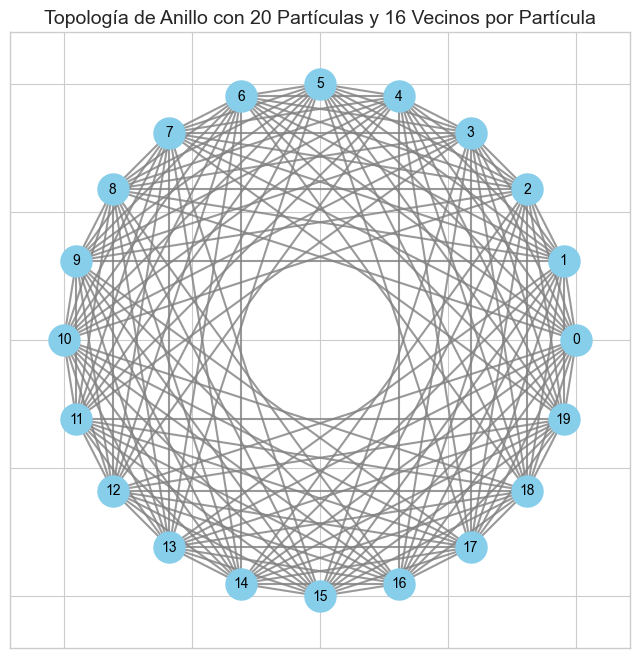


Estructura de Vecindarios (quién es vecino de quién):
Partícula  | Vecinos                       
-------------------------------------------
0          | 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19
1          | 0, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19
2          | 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19
3          | 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19
4          | 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19
5          | 0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19
6          | 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19
7          | 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 19
8          | 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16
9          | 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17
10         | 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18
11         | 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19
12         | 0, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14

In [ ]:
import networkx as nx

def visualize_neighborhood_topology(num_particles=20, num_neighbors=2):
    if num_neighbors % 2 != 0:
        print("Advertencia: El número de vecinos debe ser par para una topología simétrica.")
        return

    G = nx.Graph()
    nodes = list(range(num_particles))
    G.add_nodes_from(nodes)
    
    middle = num_neighbors // 2
    
    for i in range(num_particles):
        for j in range(1, middle + 1):
            # Conexión hacia la "izquierda" (circular)
            left_neighbor = (i - j) % num_particles
            G.add_edge(i, left_neighbor)
            
            # Conexión hacia la "derecha" (circular)
            right_neighbor = (i + j) % num_particles
            G.add_edge(i, right_neighbor)
            
    fig, ax = plt.subplots(figsize=(8, 8))
    
    pos = nx.circular_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.8, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', ax=ax)
    
    ax.set_title(f'Topología de Anillo con {num_particles} Partículas y {num_neighbors} Vecinos por Partícula', fontsize=14)
    plt.axis('equal')
    plt.show()

    print("\n" + "="*50)
    print("Estructura de Vecindarios (quién es vecino de quién):")
    print("="*50)
    
    header = f"{'Partícula':<10} | {'Vecinos':<30}"
    print(header)
    print("-" * len(header))
    
    for node in sorted(G.nodes()):
        neighbors_list = sorted(list(nx.neighbors(G, node)))
        neighbors_str = ', '.join(map(str, neighbors_list))
        print(f"{node:<10} | {neighbors_str:<30}")

visualize_neighborhood_topology(num_particles=20, num_neighbors=2)

# Ejecución de PSO

In [5]:
def run_pso_with_data_collection(particle_type: str, func: Callable, bounds: tuple, num_particles: int, max_iterations: int, dimensions: int, **kwargs):
    """
    Ejecuta el algoritmo PSO y recolecta datos detallados en cada iteración,
    incluyendo datos específicos de topología local y el mejor global.
    """
    start_time = time.time()
    
    bounds_array = np.array([bounds] * dimensions)
    
    history = {
        'positions': [],
        'best_positions': [],
        'global_best_position': [], 
        'best_neighbors': [],
        'neighborhoods': None,
        'fitness': [],
        'global_best_fitness': [],
        'diversity': [],
        'inertia_mean': [],
        'inertia_dist': []
    }
    
    particles = initializeParticles(particle_type, num_particles, dimensions, bounds_array, **kwargs)
    setupNeighborhoods(particles, particle_type)
    
    if 'local' in particle_type:
        connections = []
        for i, p in enumerate(particles):
            if hasattr(p, 'neighbors'):
                for neighbor in p.neighbors:
                    connection = tuple(sorted((i, neighbor.id - 1)))
                    if connection not in connections:
                        connections.append(connection)
        history['neighborhoods'] = connections

    global_best, global_best_fitness = findGlobalBest(particles, func)
    
    for iteration in range(max_iterations):
        history['positions'].append(np.array([p.position for p in particles]))
        history['best_positions'].append(np.array([p.bestPosition for p in particles]))
        history['global_best_position'].append(global_best.copy()) # Guardar el mejor global en cada paso
        
        if 'local' in particle_type:
            for p in particles:
                if hasattr(p, 'findBestNeighbor'):
                    p.findBestNeighbor(func)
            history['best_neighbors'].append(np.array([p.bestNeighbor for p in particles if hasattr(p, 'bestNeighbor')]))
        
        history['fitness'].append(np.array([func(p.position) for p in particles]))
        history['global_best_fitness'].append(global_best_fitness)
        history['diversity'].append(calculateDiversity(particles))
        
        if 'adaptive' in particle_type:
            history['inertia_mean'].append(np.mean([p.inertia_mean for p in particles if hasattr(p, 'inertia_mean')]))
            history['inertia_dist'].append(np.array([p.current_inertia for p in particles if hasattr(p, 'current_inertia')]))

        new_global_best, new_fitness = updateParticles(particles, particle_type, global_best, bounds_array, func)
        
        if new_fitness < global_best_fitness:
            global_best_fitness = new_fitness
            global_best = new_global_best.copy()
            
    execution_time = time.time() - start_time
    
    results = {
        'algorithm': particle_type.replace('_', ' ').title() + ' PSO',
        'best_position': global_best,
        'best_fitness': global_best_fitness,
        'execution_time': execution_time,
        'history': history
    }
    
    return results

# Resuldatos Estáticos

In [6]:
def plot_static_results(results):
    """
    Genera gráficos estáticos que resumen el rendimiento de una ejecución de PSO.
    """
    history = results['history']
    alg_name = results['algorithm']
    num_iterations = len(history['global_best_fitness'])
    iterations = range(num_iterations)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Resultados Estáticos para {alg_name}', fontsize=16)

    # Gráfico de Convergencia del Fitness
    ax1 = axes[0]
    ax1.plot(iterations, history['global_best_fitness'], label='Mejor Fitness Global')
    ax1.set_title('Convergencia del Fitness')
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Fitness')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, which="both", ls="--")

    ax2 = axes[1]
    ax2.plot(iterations, history['diversity'], color='green', label='Diversidad')
    ax2.set_title('Diversidad de la Población')
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('Distancia Promedio al Centroide')
    ax2.legend()

    ax3 = axes[2]
    if 'adaptive' in alg_name.lower():
        ax3.plot(iterations, history['inertia_mean'], color='red', label='Inercia Media (wm)')
        ax3.set_title('Evolución de la Inercia Media')
        ax3.set_xlabel('Iteración')
        ax3.set_ylabel('Valor de Inercia')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'Inercia no adaptativa', ha='center', va='center', fontsize=12, alpha=0.5)
        ax3.set_title('Inercia')
        ax3.set_xticks([])
        ax3.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Resultados animados

In [7]:
# --- Celda 6: Función para crear la animación (MEJORADA con visualización local/global) ---

from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

def create_animation(results, func, bounds, save_path):
    history = results['history']
    alg_name = results['algorithm']
    num_iterations = len(history['positions'])
    is_local_alg = 'local' in alg_name.lower()
        
    x_grid = np.linspace(bounds[0], bounds[1], 100)
    y_grid = np.linspace(bounds[0], bounds[1], 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.array([func(np.array([x_i, y_i])) for x_i, y_i in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

    fig = plt.figure(figsize=(18, 6.5))
    gs = fig.add_gridspec(2, 3)

    ax_main = fig.add_subplot(gs[:, 0])
    ax_fitness = fig.add_subplot(gs[0, 1])
    ax_inertia_conv = fig.add_subplot(gs[1, 1])
    ax_inertia_hist = fig.add_subplot(gs[1, 2])

    ax_main.set_title(f'Evolución de Partículas ({alg_name})')
    ax_main.contourf(X, Y, Z, levels=50, cmap='gray', alpha=0.5)
    ax_main.set_xlim(bounds)
    ax_main.set_ylim(bounds)
    ax_main.set_xlabel('Dimensión X')
    ax_main.set_ylabel('Dimensión Y')
    ax_main.set_aspect('equal', adjustable='box')
    
    particles_scatter = ax_main.scatter([], [], c='red', s=40, zorder=4, label='Partículas')
    best_pos_scatter = ax_main.scatter([], [], c='cyan', s=20, zorder=3, label='Mejor Personal')
    global_best_scatter = ax_main.scatter([], [], c='gold', s=150, marker='*', edgecolors='black', linewidth=1.5, zorder=5, label='Mejor Global')

    best_neighbor_scatter = None
    neighborhood_lines = []
    if is_local_alg:
        best_neighbor_scatter = ax_main.scatter([], [], c='lime', s=50, marker='s', zorder=3, label='Mejor Vecino')
        if history['neighborhoods']:
            for _ in history['neighborhoods']:
                line, = ax_main.plot([], [], 'gray', alpha=0.4, linewidth=1, zorder=1)
                neighborhood_lines.append(line)

    ax_main.legend(loc='upper right')

    ax_fitness.set_title('Convergencia del Fitness')
    ax_fitness.set_xlabel('Iteración')
    ax_fitness.set_ylabel('Mejor Fitness Global')
    ax_fitness.set_yscale('log')
    fitness_line, = ax_fitness.plot([], [], 'b-')
    ax_fitness.set_xlim(0, num_iterations)
    min_fit, max_fit = np.min(history['global_best_fitness']), np.max(history['global_best_fitness'])
    ax_fitness.set_ylim(min_fit - (max_fit-min_fit)*0.1 if min_fit!=max_fit else min_fit-1, max_fit + (max_fit-min_fit)*0.1 if min_fit!=max_fit else max_fit+1)
    
    ax_inertia_conv.set_title('Evolución de Inercia Media')
    ax_inertia_conv.set_xlabel('Iteración')
    ax_inertia_conv.set_ylabel('Inercia Media')
    inertia_line, = ax_inertia_conv.plot([], [], 'r-')
    if 'adaptive' in alg_name.lower() and history['inertia_mean']:
        ax_inertia_conv.set_xlim(0, num_iterations)
        min_inertia, max_inertia = np.min(history['inertia_mean']), np.max(history['inertia_mean'])
        ax_inertia_conv.set_ylim(min_inertia*0.9, max_inertia*1.1)

    ax_inertia_hist.set_title('Distribución de Inercia Actual')
    ax_inertia_hist.set_xlabel('Valor de Inercia')
    ax_inertia_hist.set_ylabel('Frecuencia')
    ax_inertia_hist.set_xlim(0, 1)

    fig.tight_layout()

    def animate(i):
        particles_scatter.set_offsets(history['positions'][i])
        best_pos_scatter.set_offsets(history['best_positions'][i])
        global_best_scatter.set_offsets(history['global_best_position'][i])
        
        if is_local_alg:
            if best_neighbor_scatter is not None and len(history['best_neighbors']) > i:
                best_neighbor_scatter.set_offsets(history['best_neighbors'][i])
            
            for line_idx, (p1_idx, p2_idx) in enumerate(history['neighborhoods']):
                if line_idx < len(neighborhood_lines):
                    p1_pos = history['positions'][i][p1_idx]
                    p2_pos = history['positions'][i][p2_idx]
                    neighborhood_lines[line_idx].set_data([p1_pos[0], p2_pos[0]], [p1_pos[1], p2_pos[1]])

        fitness_line.set_data(range(i + 1), history['global_best_fitness'][:i + 1])
        
        if 'adaptive' in alg_name.lower() and history['inertia_mean']:
            inertia_line.set_data(range(i+1), history['inertia_mean'][:i+1])
            ax_inertia_hist.clear()
            ax_inertia_hist.hist(history['inertia_dist'][i], bins=np.linspace(0, 1, 11), color='orange', edgecolor='black')
            ax_inertia_hist.set_title('Distribución de Inercia Actual')
            ax_inertia_hist.set_xlim(0, 1)
            ax_inertia_hist.set_ylim(0, len(history['positions'][0])/2)
        
        return particles_scatter, best_pos_scatter, global_best_scatter

    anim = FuncAnimation(fig, animate, frames=num_iterations, interval=100, blit=False)
    
    # Guardar la animación
    print(f"Guardando animación en {save_path}...")
    writer = FFMpegWriter(fps=15, metadata=dict(artist='Gemini'), bitrate=1800)
    try:
        anim.save(save_path, writer=writer)
        print("Guardado completo.")
    except FileNotFoundError:
        print("\n*** ERROR: `ffmpeg` no encontrado. ***")
        plt.close(fig)
        return None

    plt.close(fig)
    return save_path

# Interfaz

In [8]:
# --- Parámetros de la Simulación ---
NUM_PARTICLES = 100
MAX_ITERATIONS = 300
DIMENSIONS = 2

# --- Diccionarios para selección ---
algorithms = {
    'Global PSO': 'global',
    'Local PSO': 'local',
    'Adaptive PSO': 'adaptive',
    'Adaptive Local PSO': 'adaptive_local'
}

objective_functions = {
    'Rastrigin': (rastrigin, (-5.12, 5.12))
}

alg_dropdown = widgets.Dropdown(
    options=algorithms.keys(), 
    description='Algoritmo:',
    style={'description_width': 'initial'}
)
func_dropdown = widgets.Dropdown(
    options=objective_functions.keys(), 
    description='Función:',
    style={'description_width': 'initial'}
)
run_button = widgets.Button(
    description="Ejecutar y Visualizar", 
    button_style='success',
    tooltip='Haz clic para iniciar la simulación completa',
    icon='cogs'
)
output_area = widgets.Output()

def on_run_button_clicked(b):
    """
    Esta función se ejecuta cuando se hace clic en el botón 'Ejecutar y Visualizar'.
    Orquesta todo el proceso: simulación, análisis estático y generación de animación.
    """
    with output_area:
        clear_output(wait=True)
        
        alg_key = alg_dropdown.value
        func_key = func_dropdown.value
        
        particle_type = algorithms[alg_key]
        func, bounds = objective_functions[func_key]
        
        print(f"--- Iniciando Simulación ---")
        print(f"Algoritmo: {alg_key}")
        print(f"Función Objetivo: {func_key}")
        print(f"Límites del Dominio: {bounds}")
        print("--------------------------\n")

        print("1. Visualización de la Función Objetivo:")
        plot_objective_function(func, bounds, func_key)
        
        print("\n2. Ejecutando simulación para recolectar datos...")
        results = run_pso_with_data_collection(
            particle_type=particle_type,
            func=func,
            bounds=bounds,
            num_particles=NUM_PARTICLES,
            max_iterations=MAX_ITERATIONS,
            dimensions=DIMENSIONS,
            num_neighbors=2
        )
        print("Simulación completada.")
        print(f"Mejor fitness encontrado: {results['best_fitness']:.6f}\n")
        
        print("3. Gráficos de Resultados Estáticos:")
        plot_static_results(results)
        
        print("\n4. Generando Animación MP4 (esto puede tardar un momento)...")
        save_path = f'animation_{particle_type}_{func.__name__}.mp4'
        
        video_path = create_animation(results, func, bounds, save_path=save_path)
        
        if video_path:
            print(f"Mostrando video guardado en: {video_path}")
            display(Video(video_path, embed=True, width=800))
        else:
            print("No se pudo generar la animación.")


run_button.on_click(on_run_button_clicked)

controls = widgets.HBox([alg_dropdown, func_dropdown])
interface = widgets.VBox([controls, run_button, output_area])

display(interface)